In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [2]:
# get the DGD modules (once the current version is public we can switch to the repo)
#git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from src.dgd.latent import RepresentationLayer
from src.dgd.latent import GaussianMixture
from src.dgd.nn import NB_Module

# get the new stuff
from src.utils.helpers import set_seed
from src.model.decoder import Decoder
from src.data.dataset import GeneExpressionDataset

In [3]:
# set random seeds, device and data directory
seed = 0
set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datadir="./data/"

In [4]:
# get gtex data just for testing

# uncomment to download the data
#!wget https://zenodo.org/record/7828660/files/gtex_with_cancer.csv.gz

gtex_raw = pd.read_table("gtex_with_cancer.csv.gz",sep='\t')

# make data split for train and validation sets
out_dim = gtex_raw.shape[1]-1
train_ratio = 0.9
train_data = gtex_raw.iloc[:int(train_ratio*len(gtex_raw)),:]
test_data = gtex_raw.iloc[int(train_ratio*len(gtex_raw)):,:]

# define scaling for NB
# each sample gets a scaling factor
scaling_factors = torch.mean(torch.Tensor(train_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
test_scaling_factors = torch.mean(torch.Tensor(test_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)

# make data loaders
train_loader = torch.utils.data.DataLoader(GeneExpressionDataset(train_data),
                                          batch_size=256,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(GeneExpressionDataset(test_data),
                                          batch_size=256,
                                          shuffle=True)

In [31]:
out_dim

5000

In [40]:
n_tissues = len(gtex_raw["tissue"].unique())
n_tissues # bit too high with cancer types
n_tissues = 30

In [6]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 128, 128]
reduction_type = "sum" # output loss reduction

In [41]:
# decoder setup

# set up an output module for the expression data
gex_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], out_dim)
    )
output_gex_layer = NB_Module(gex_out_fc, out_dim, scaling_type="mean")
output_gex_layer.n_features = out_dim

# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_gex_layer]).to(device)

### specific code (DGD collection and training loop) as examples

In [36]:
# combine everything in one class (if desired)

class DGD(nn.Module):
    def __init__(self,decoder,n_mix,rep_dim,gmm_spec={}):
        super(DGD, self).__init__()
        self.decoder=decoder
        self.rep_dim = rep_dim      # Dimension of representation

        self.gmm=GaussianMixture(n_mix,rep_dim,**gmm_spec)
        self.train_rep=None
        self.val_rep=None

    def forward(self,z):
        return self.decoder(z)

    def loss(self,z,y,target,scale,gmm_loss=True,reduction="sum"):
        self.dec_loss = self.decoder.loss(y,target,scale,reduction=reduction)
        if gmm_loss:
            self.gmm_loss = self.gmm(z)
            if reduction=="mean":
                self.gmm_loss = self.gmm_loss.mean()
            else:
                self.gmm_loss = self.gmm_loss.sum()
            return self.dec_loss, self.gmm_loss
        else:
            return self.dec_loss, None
    
    def forward_and_loss(self,z,target,scale,gmm_loss=True,reduction="sum"):
        y = self.decoder(z)
        return self.loss(z,y[0],target,scale,gmm_loss,reduction)

In [37]:
# write a minimal training function

def train_dgd(dgd, train_loader, validation_loader, device, learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},weight_decay=0.,nepochs=100,pr=1,reduction_type="sum"):
    Ntrain=len(train_loader.dataset)
    Nvalidation=len(validation_loader.dataset)
    if dgd.train_rep is None:
        dgd.train_rep = RepresentationLayer(dgd.rep_dim,Ntrain).to(device)
    Nvalidation=len(validation_loader.dataset)
    if dgd.val_rep is None:
        dgd.val_rep = RepresentationLayer(dgd.rep_dim,Nvalidation).to(device)

    dec_optimizer = torch.optim.AdamW(dgd.decoder.parameters(), lr=learning_rates['dec'])
    gmm_optimizer = torch.optim.AdamW(dgd.gmm.parameters(), lr=learning_rates['gmm'])
    train_rep_optimizer = torch.optim.AdamW(dgd.train_rep.parameters(), lr=learning_rates['rep'])
    val_rep_optimizer = torch.optim.AdamW(dgd.val_rep.parameters(), lr=learning_rates['rep'])

    loss_tab = {"Epoch":[],"Train recon":[],"Test recon":[],
                "GMM train":[],"GMM test":[]}
    best_loss=1.e20
    # length of dataloader
    tlen=len(train_loader)
    vlen=len(validation_loader)
    gmm_loss=True
    dgd.train()
    for epoch in range(nepochs):
        loss_tab["Epoch"].append(epoch)
        loss_tab["Train recon"].append(0.)
        loss_tab["GMM train"].append(0.)

        train_rep_optimizer.zero_grad()
        for x, lib, index in train_loader:
            dec_optimizer.zero_grad()
            if gmm_loss: gmm_optimizer.zero_grad()
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.train_rep(index),[x.to(device)],[lib.unsqueeze(1).to(device)],
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Train recon"][-1] += recon_loss.item()
            loss_tab["GMM train"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
            dec_optimizer.step()
            if gmm_loss: gmm_optimizer.step()
            #return None
        train_rep_optimizer.step()

        loss_tab["Train recon"][-1] /= tlen
        loss_tab["GMM train"][-1] /= Ntrain

        # Validation data
        loss_tab["Test recon"].append(0.)
        loss_tab["GMM test"].append(0.)
        val_rep_optimizer.zero_grad()
        dgd.eval()
        for x, lib, index in validation_loader:
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.val_rep(index),[x.to(device)],[lib.unsqueeze(1).to(device)],
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Test recon"][-1] += recon_loss.item()
            loss_tab["GMM test"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
        val_rep_optimizer.step()

        loss_tab["Test recon"][-1] /= vlen
        loss_tab["GMM test"][-1] /= Nvalidation

        if pr>0 and (epoch+1)%pr==0:
            print(epoch+1, loss_tab["Train recon"][-1], loss_tab["Test recon"][-1])
    
    return loss_tab

### test

In [42]:
# init a DGD model

gmm_mean_scale = 5.0
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

In [43]:
# train for 10 epochs and plot learning curves
n_epochs = 10
pr = 1 # how often to print

loss_tab = train_dgd(
    dgd, train_loader, test_loader, device, 
    learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},
    weight_decay=0.,nepochs=n_epochs,pr=pr,reduction_type=reduction_type
    )
# stuff is running but I have to check the loss normalization for printing and plotting, they seem a bit large

1 17325218.108695652 15462093.090909092
2 16480762.391304348 15415460.818181818
3 16413181.02173913 15371757.886363637
4 16358219.336956521 15306838.181818182
5 16304475.956521738 15277751.590909092
6 16265561.77173913 15253143.0
7 16220607.173913043 15200751.409090908
8 16185924.217391305 15171438.409090908
9 16153484.663043479 15155415.113636363
10 16121340.608695652 15120802.5


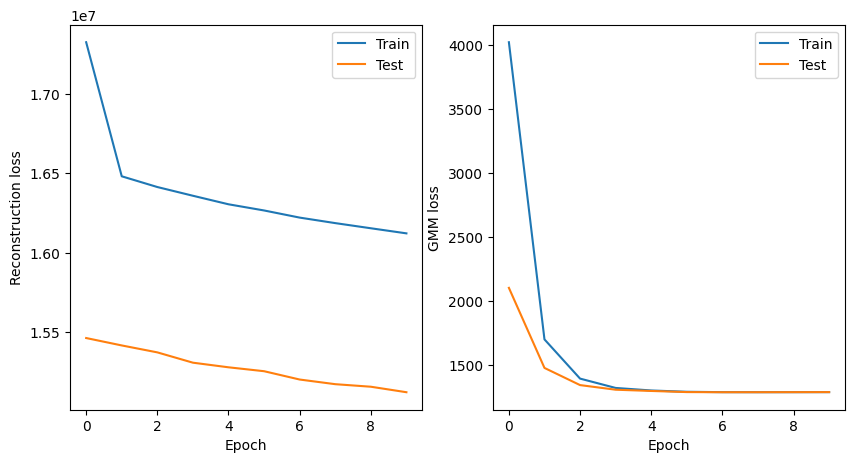

In [45]:
import matplotlib.pyplot as plt
# make 2 subplots with recon and gmm loss curves
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_tab["Epoch"],loss_tab["Train recon"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Test recon"],label="Test")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss_tab["Epoch"],loss_tab["GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["GMM test"],label="Test")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")
plt.legend()
plt.show()